### Project :: Evolution Strategies

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

Remember the idea behind Evolution Strategies? Here's a neat [blog post](https://openai.com/research/evolution-strategies) about 'em.

Can you reproduce their success? You will have to implement evolutionary strategies and see how they work.

This project is optional; has several milestones each worth a number of points [and swag].

__Milestones:__
* [10pts] Basic prototype of evolutionary strategies that works in one thread on CartPole
* [+5pts] Modify the code to make them work in parallel
* [+5pts] if you can run ES distributedly on at least two PCs
* [+10pts] Apply ES to play Atari Pong at least better than random
* [++] Additional points for all kinds of cool stuff besides milestones

__Rules:__

* This is __not a mandatory assignment__, but it's a way to learn some cool things if you're getting bored with default assignments.
* Once you decided to take on this project, please tell any of course staff members so that we can help ypu if you get stuck.
* There's a default implementation of ES in this [openai repo](https://github.com/openai/evolution-strategies-starter). It's okay to look there if you get stuck or want to compare your solutions, but each copy-pasted chunk of code should be understood thoroughly. We'll test that with questions.

### Tips on implementation

* It would be very convenient later if you implemented a function that takes policy weights, generates a session and returns policy changes -- so that you could then run a bunch of them in parallel.

* The simplest way you can do multiprocessing is to use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)

* For joblib, make sure random variables are independent in each job. Simply add `np.random.seed()` at the beginning of your "job" function.

Later once you got distributed, you may need a storage that gathers gradients from all workers. In such case we recommend [Redis](https://redis.io/) due to it's simplicity.

Here's a speed-optimized saver/loader to store numpy arrays in Redis as strings.



In [1]:
import sys

In [2]:
import joblib
from six import BytesIO


def dumps(data):
    """converts whatever to string"""
    s = BytesIO()
    joblib.dump(data, s)
    return s.getvalue()


def loads(self, string):
    """converts string to whatever was dumps'ed in it"""
    return joblib.load(BytesIO(string))

### Tips on Atari games
* There's all the pre-processing and tuning done for you in the code below
    * Images rescaled to 42x42 to speed up computation
    * We use last 4 frames as observations to account for ball velocity
    * The code below requires ```pip install Image``` and ```pip install gym[atari]``` 
    * You may also need some dependencies for gym[atari] - google "gym install all" dependencies or use our pre-built environment.
* The recommended agent architecture is a convolutional neural network. Dense network will also do.


May the force be with you!

In [3]:
import os

os.chdir('courses/Practical_RL/week01_intro/')
!ls

crossentropy_method.ipynb
deep_crossentropy_method-continious.ipynb
deep_crossentropy_method.ipynb
LunarLander-v2_agent_10.pth
LunarLander-v2_agent_12.pth
LunarLander-v2_agent_13.pth
LunarLander-v2_agent_4.pth
LunarLander-v2_agent_9.pth
LunarLander-v2_log_10.pkl
LunarLander-v2_log_12.pkl
LunarLander-v2_log_13.pkl
LunarLander-v2_log_4.pkl
LunarLander-v2_log_9.pkl
pong_agent_{experiment_id}.pth
pong_agent_log_10.pkl
pong_agent_log_11.pkl
pong_agent_log_12.pkl
pong_agent_log_13.pkl
pong_agent_log_14.pkl
pong_agent_log_15.pkl
pong_agent_log_16.pkl
pong_agent_log_17.pkl
pong_agent_log_18.pkl
pong_agent_log_19.pkl
pong_agent_log_20.pkl
pong_agent_log_21.pkl
pong_agent_log_22.pkl
pong_agent_log_24.pkl
pong_agent_log_25.pkl
pong_agent_log_26.pkl
pong_agent_log_27.pkl
pong_agent_log_28.pkl
pong_agent_log_29.pkl
pong_agent_log_2.pkl
pong_agent_log_30.pkl
pong_agent_log_31.pkl
pong_agent_log_3.pkl
pong_agent_log_4.pkl
pong_agent_log_5.pkl
pong_agent_log_6.pkl
pong_agent_log_7.pkl
pong_agent_log_8

In [4]:
from pong import make_pong
import numpy as np
import gym

env_name = 'LunarLander-v2'
env = gym.make(env_name)
print(env.action_space)

Discrete(4)


In [5]:
# get the initial state
s, _ = env.reset()
print(s.shape)

(8,)


In [6]:
# next frame
new_s, r, done, is_truncated, _ = env.step(env.action_space.sample())

/home/morph/anaconda3/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [7]:
# after 10 frames
for _ in range(10):
    new_s, r, done, is_truncated, _ = env.step(env.action_space.sample())
    print(r)

-2.9321957063698845
-1.0636309257969174
-4.925438125005729
0.48956620602987755
1.3540046046182124
-2.6377041615194683
0.6812425755601907
0.6826900504109403
0.6798159553314349
-0.09180985301443798


## [+10pts] Apply ES to Lunar Lander

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import os

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

input_shape = (8,)
n_actions = env.action_space.n
class MLP(nn.Module):
    def __init__(self, input_shape, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(input_shape[0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.head = nn.Linear(64, num_actions)

    def forward(self, x):
        assert x.shape[1:] == input_shape
        x = x.float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(x)
        return self.head(x)
        
agent = MLP(input_shape, n_actions)
n_actions

4

In [11]:
from PIL import Image
from collections import Counter

def generate_session(env, agent, t_max=1000, video_recorder=None, softmax_to_argmax=0.5):
    state, _ = env.reset()
    total_reward = 0
    actions = []
    for t in range(t_max):
        # use agent to predict a vector of action probabilities for state :s:
        state = torch.tensor(state.reshape((1,) + state.shape), dtype=torch.float32)
        logits = agent(state)
        if softmax_to_argmax < 0.001:
            softmax_to_argmax = 0.001
        probs = torch.softmax(logits / softmax_to_argmax, dim=1)[0].detach().numpy()
        a = np.random.choice(n_actions, p=probs)
        # a = np.argmax(probs)
        actions.append(a)
        # apply action to the environment, get rewards and new state
        state, r, done, is_trucanted, info = env.step(a)
        total_reward += r

        # record session if a video_recorder object is provided
        if video_recorder is not None:
            video_recorder.capture_frame()

        if done:
            break
    # print(total_reward, Counter(actions).most_common(), file=sys.stderr)

    return total_reward

In [12]:
dummy_reward = generate_session(env, agent, t_max=100)
print("reward:", dummy_reward)

reward: -61.0714206676573


In [13]:
from IPython.display import clear_output

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def show_progress(rewards_batch, log, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    
    clear_output(True)
    print("mean reward = %.3f" % (mean_reward))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(moving_average([r[0] for r in log], 5), label='Mean rewards')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range, bins=50)
    plt.legend()
    plt.grid()

    plt.show()

In [14]:
log = []

In [15]:
from collections import OrderedDict

def get_agent_parameters(agent):
    return np.concatenate([
        p.detach().numpy().flatten() 
        for p in agent.parameters()
    ])

def set_agent_parameters(agent, parameters):
    shapes = [p.shape for p in agent.parameters()]
    total_size = sum(np.product(s) for s in shapes)
    assert total_size == parameters.shape[0], "number of parameters should be %i but is %i" % (total_size, parameters.shape[0])
    
    split_ix = np.cumsum([np.product(s) for s in shapes])[:-1]
    split_parameters = np.split(parameters, split_ix)
    reshaped_parameters = [torch.tensor(p.reshape(s)) for p, s in zip(split_parameters, shapes)]
    
    state_dict = OrderedDict(zip(agent.state_dict().keys(), reshaped_parameters))
    agent.load_state_dict(state_dict)

In [16]:
parameters = get_agent_parameters(agent)
set_agent_parameters(agent, parameters)

In [17]:
REWARD_WIN = 1000

In [18]:
experiment_id = 13
reward_log_name = f'{env_name}_log_{experiment_id}.pkl'
agent_weights_name = f'{env_name}_agent_{experiment_id}.pth'
start_with_best = True

In [19]:
import joblib
from joblib import Parallel, delayed

if start_with_best:
    try:
        log = joblib.load(reward_log_name)
        agent = MLP(input_shape, n_actions)
        agent.load_state_dict(torch.load(agent_weights_name))
    except FileNotFoundError:
        pass

In [20]:
import seaborn

seaborn.set()

In [21]:
# import itertools
from tqdm.auto import tqdm
import numpy as np
import warnings

def calculate_noise_reward(agent, parameters, noise_batch, sigma, t_max, softmax_to_argmax):
    with warnings.catch_warnings():
        if n_jobs > 1: 
            import os, sys

            os.chdir('/home/morph/projects/courses/Practical_RL/week01_intro')
            sys.path.append('.')

            from pong import make_pong
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        env = gym.make(env_name)
        R = []
        for noise in noise_batch:
            noised_parameters = parameters + sigma * noise
            set_agent_parameters(agent, noised_parameters)
            R.append(generate_session(env, agent, t_max=t_max, softmax_to_argmax=softmax_to_argmax))

    return R

def calculate_rewards_batch(agent, parameters, npop, sigma, t_max, softmax_to_argmax):
    N = np.random.randn(npop // 2, parameters.shape[0])
    N = np.vstack([N, -N])

    assert npop % n_jobs == 0, "npop should be divisible by n_jobs"
    batch_size = npop // n_jobs
    R = Parallel(n_jobs=n_jobs)(
        delayed(calculate_noise_reward)(agent, parameters, N[batch_j * batch_size:(batch_j + 1) * batch_size], sigma, t_max, softmax_to_argmax)
        for batch_j in range(npop // batch_size)
    )
    R = np.concatenate(R)
    return R, N

class ReplayBuffer:
    def __init__(self, size):
        self.buffer = []
        self.size = size

    def add(self, parameters, reward):
        self.buffer.append((parameters, reward))
        if len(self.buffer) > self.size:
            self.buffer.pop(0)

    def get(self):
        return self.buffer

replay_buffer = ReplayBuffer(size=100000)


def compute_ranks(x):
    """
    Returns ranks in [0, len(x))
    Note: This is different from scipy.stats.rankdata, which returns ranks in [1, len(x)].
    """
    assert x.ndim == 1
    ranks = np.empty(len(x), dtype=int)
    ranks[x.argsort()] = np.arange(len(x))
    return ranks


def compute_centered_ranks(x):
    y = compute_ranks(x.ravel()).reshape(x.shape).astype(np.float32)
    y /= (x.size - 1)
    y -= .5
    return y

def update_parameters(parameters, alpha, npop, sigma, R, N, clip_value, replay_buffer=None):
    """
    Update the parameters using new and past experiences with clipping.

    Parameters:
    parameters (np.array): The current parameters.
    alpha (float): The learning rate.
    npop (int): The population size.
    sigma (float): The noise standard deviation.
    A (np.array): The normalized rewards.
    N (np.array): The noise vectors.
    replay_buffer (ReplayBuffer): The replay buffer to store and retrieve past experiences.
    threshold (float): The maximum allowed distance for past parameters.
    clip_value (float): The maximum allowed change for the parameters.

    Returns:
    np.array: The updated parameters.
    """

    if replay_buffer is not None:
        d = np.prod(parameters.shape)  # the total number of parameters
        threshold = np.sqrt(d) * sigma

        # Gather all the noise and rewards that are close enough to the current parameters
        close_noise = []
        close_rewards = []
        for old_parameters, old_reward in replay_buffer.get():
            if np.linalg.norm(old_parameters - parameters) < threshold:
                old_noise = (old_parameters - parameters) / sigma
                close_noise.append(old_noise)
                close_rewards.append(old_reward)
                
        for n, r in zip(N, R):
            replay_buffer.add(parameters + sigma * n, r)
            
        # Combine the new and close old noise and rewards
        if len(close_noise) > 0:
            N = np.vstack((N, np.row_stack(close_noise)))
            R = np.concatenate([R, np.array(close_rewards)])

    R_ranks = compute_centered_ranks(R)
    std = np.std(R_ranks)
    mean = np.mean(R_ranks)
    A = (R_ranks - mean) / (0.00001 + std)

    # Calculate the combined update
    update = alpha / (N.shape[0] * sigma) * np.dot(N.T, A)

    # Clip the update to prevent too large changes
    clipped_update = np.clip(update, -clip_value, clip_value)

    # Apply the update
    parameters += clipped_update
    clipped_ratio = np.mean(update != clipped_update)
    parameters *= weight_decay

    return parameters, R, clipped_ratio


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


mean reward = 0.000


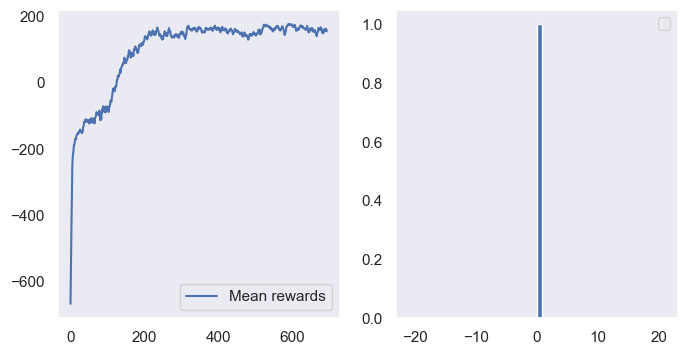

In [25]:
if log: 
    show_progress([0], log, reward_range=[-21, 21])

In [23]:
1

mean reward = 0.000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


mean reward = 172.027


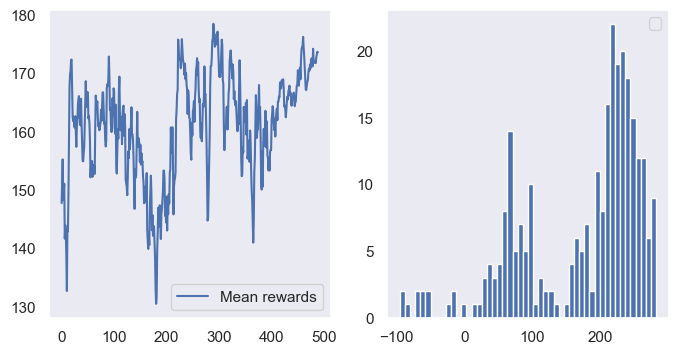

reward=172.03, randomness=0.000, clipped=0.00, weights_sum=9.8, rewards_count=280


KeyboardInterrupt: 

In [43]:
sigma = 0.01   # noise standard deviation
alpha = 0.0001  # learning rate
n_jobs = 7
npop = n_jobs * 40      # population size
determenistic_speed = 0.999
clip_value = 0.005
determenistic_start = 0.0001
weight_decay = 1.0
replay_buffer = None
t_max = 2000

best_reward = max([r[0] for r in log], default=-1000000)
softmax_to_argmax = determenistic_start * determenistic_speed ** len(log)

for i in range(100000):
    parameters = get_agent_parameters(agent)
    R, N = calculate_rewards_batch(agent, parameters, npop, sigma, t_max, softmax_to_argmax)
    mean = np.mean(R)
    if mean > best_reward:
        best_reward = mean
        torch.save(agent.state_dict(), agent_weights_name)
        joblib.dump(log, open(reward_log_name, 'wb'))
        print("New best reward:", best_reward)

    # Update parameters with PPO-like penalty
    parameters, R, clipped_ratio = update_parameters(parameters, alpha, npop, sigma, R, N, clip_value=clip_value, replay_buffer=replay_buffer)
    
    set_agent_parameters(agent, parameters)
    log.append([mean])
    
    if i % 1 == 0:
        show_progress(R, log[300:], reward_range=[min(np.min(R), 0), np.max(R)])
        if np.mean(R) >= REWARD_WIN:
            print("You Win!")
            break

    softmax_to_argmax *= determenistic_speed
    print(f"reward={mean:.2f}, randomness={softmax_to_argmax:.3f}, clipped={clipped_ratio:.2f}, weights_sum={np.linalg.norm(parameters):.1f}, rewards_count={len(R):d}")


In [39]:
import skvideo.io
import gym

class VideoRecorder(gym.Wrapper):
    def __init__(self, env, path=None, metadata=None, enabled=True):
        super().__init__(env)
        self.enabled = enabled
        self.metadata = metadata or {}
        self.path = path
        self.frames = []
        self.render_history = []
        self.encoder = None

    def capture_frame(self):
        frame = self.env.render()
        self.frames.append(frame)

    def close(self):
        try:
            if self.encoder is not None:
                self.encoder.close()
                self.encoder = None
            if self.path:
                if self.frames:
                    skvideo.io.vwrite(self.path, self.frames)
                self.frames = []
        except Exception as e:
            print(f"Error when closing video recorder: {e}")

    @property
    def functional(self):
        """Returns if the video recorder is functional, is enabled and not closed."""
        return self.enabled and not self.closed

In [42]:
env = gym.make(env_name, render_mode='rgb_array')
env_monitor = VideoRecorder(env, path="videos/video.mp4")
env_monitor.enabled = True

rewards = []
for i in range(10):
    reward = generate_session(env, agent, t_max, video_recorder=env_monitor, softmax_to_argmax=softmax_to_argmax)
    rewards.append(reward)
    print(f"Session {i+1}: reward={reward:.2f}")

env_monitor.close()
print(f"Average reward: {np.mean(rewards):.2f}")

Session 1: reward=224.76
Session 2: reward=169.31
Session 3: reward=48.36
Session 4: reward=193.75
Session 5: reward=180.82
Session 6: reward=235.34
Session 7: reward=241.52
Session 8: reward=225.02
Session 9: reward=271.95
Session 10: reward=169.00
Average reward: 195.98
